### Source-only (with .train and .eval() modes)

In [1]:
# import modules and libraries
import torch
import torch.nn as nn
from torch.optim import Adam

# functions to create datasets and models
from data.data import *
from models.models import *

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available')
else:
    print('CUDA is available')
    device = torch.device('cuda')

CUDA is available


### Parameters

In [3]:
"""Parameters for this experiment"""
# params for loading the data
path = 'data/CWRU/bearing/'
source_domain = 'A'
target_domains = ['B', 'C', 'D', 'E', 'F', 'G', 'H']

# params for configuring the model
input_dim = 1
hidden_dim = 256
output_dim = 10
drop_prob = 0.5

# params for training the model
epochs_pre = 30 # pre-training
epochs = 30

# optimizing the model
lr = 1e-4
batch_size = 20
beta1 = 0.5
beta2 = 0.9

### Data Loading

In [4]:
# source domain data for training, validating and testing
train_dataloader_src, val_dataloader_src, test_dataloader_src = generate_dataloaders(path, source_domain, batch_size)

# target domain data for validating and testing
train_dataloader_tgt, val_dataloader_tgt, test_dataloader_tgt = [], [], []
for target_domain in target_domains:
    train_dataloader_temp, val_dataloader_temp, test_dataloader_temp = generate_dataloaders(path, target_domain, batch_size)
    
    train_dataloader_tgt.append(train_dataloader_temp)
    val_dataloader_tgt.append(val_dataloader_temp)
    test_dataloader_tgt.append(test_dataloader_temp)

### Model

In [5]:
encoder_src = Encoder_AMDA(
    input_dim=input_dim, # 1D input (sensor readings)
    hidden_dim=hidden_dim # hidden layers 64
)

classifier = Classifier_AMDA(
    hidden_dim=hidden_dim, # hidden layers 64
    output_dim=output_dim, # 3 classes (healthy, inner- and outer-bearing damages)
    dropout=drop_prob # dropout prob 0.5
)

encoder_tgt = Encoder_AMDA(
    input_dim=input_dim, # 1D input (sensor readings)
    hidden_dim=hidden_dim, # hidden layers 64
)

if train_on_gpu:
    encoder_src = encoder_src.to(device)
    classifier = classifier.to(device)
    encoder_tgt = encoder_tgt.to(device)

#### Functions for training and testing the model

In [6]:
# functions for training source encoder and shared classifier
def train_src(encoder, classifier):
    """Train the source encoder and shared classifier on source domain"""
    encoder.train()
    classifier.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(
        list(encoder.parameters()) + list(classifier.parameters()),
        lr=lr,
        betas=(beta1, beta2)
    )

    for epoch in range(epochs_pre):
        accuracies = []
        losses = []

        for batch_idx, (x_src, y_src) in enumerate(train_dataloader_src):
            if train_on_gpu:
                x_src, y_src = x_src.to(device), y_src.to(device)

            optimizer.zero_grad()

            e_src = encoder(x_src)
            pred_src = classifier(e_src)
            loss_src = criterion(pred_src, y_src)
            loss_src.backward()

            optimizer.step()

            losses.append(loss_src.detach().item()) # detach the loss from compute graph 
            accuracies.append(y_src.eq(pred_src.detach().argmax(dim=1)).float().mean())
        
        # print for each epoch
        print(f'Epoch: {epoch + 1} \n \t Train Loss:{torch.tensor(losses).mean():0.2f} \t Train Acc:{torch.tensor(accuracies).mean():0.2f}')

        # for each epoch, evaluate your model on the validation data
        val_loss, val_acc = evaluate_src(encoder, classifier, phase = 'Val')
        print(f'\t Val Loss:{val_loss:0.2f} \t\t Val Acc:{val_acc:0.2f}')

    return encoder, classifier

# testing model on source domain
def evaluate_src(encoder, classifier, phase='Val'): # phase can be validate or test
    """Evaluate the trained network on source domain"""
    encoder.eval()
    classifier.eval()

    criterion = nn.CrossEntropyLoss()
    
    losses = []
    accuracies = []
    dataloader = val_dataloader_src if phase == 'Val' else test_dataloader_src
    
    with torch.no_grad():
        for batch_idx, (x_src, y_src) in enumerate(dataloader):
            if train_on_gpu:
                x_src, y_src = x_src.to(device), y_src.to(device)

            e_src = encoder(x_src)
            pred_src = classifier(e_src)
            loss_src = criterion(pred_src, y_src)
            
            # append loss for each batch
            losses.append(loss_src.detach().item()) # detach the loss from compute graph 
            accuracies.append(y_src.eq(pred_src.detach().argmax(dim=1)).float().mean())
            
        mean_loss = torch.tensor(losses).mean()
        mean_acc = torch.tensor(accuracies).mean()
        return mean_loss, mean_acc

In [7]:
# testing model on target domains
def evaluate_tgt(encoder, classifier, dataloader):
    """Evaluate the network on current target domain"""
    encoder.eval()
    classifier.eval()

    criterion = nn.CrossEntropyLoss()
    
    losses = []
    accuracies = []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(dataloader): # target dataloader
            if(train_on_gpu):
                x, y = x.to(device), y.to(device)

            pred_tgt = classifier(encoder(x))
            loss_tgt = criterion(pred_tgt, y)
            
            # append loss for each batch
            losses.append(loss_tgt.detach().item()) # detach the loss from compute graph 
            accuracies.append(y.eq(pred_tgt.detach().argmax(dim=1)).float().mean())
            
        mean_loss = torch.tensor(losses).mean()
        mean_acc = torch.tensor(accuracies).mean()
        return mean_loss, mean_acc

In [8]:
# testing model on target domains with BN/Dropout
def evaluate_tgt_train_mode(encoder, classifier, dataloader):
    """Evaluate the network on current target domain"""
    encoder.train()
    classifier.train()

    criterion = nn.CrossEntropyLoss()
    
    losses = []
    accuracies = []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(dataloader): # target dataloader
            if(train_on_gpu):
                x, y = x.to(device), y.to(device)

            pred_tgt = classifier(encoder(x))
            loss_tgt = criterion(pred_tgt, y)
            
            # append loss for each batch
            losses.append(loss_tgt.detach().item()) # detach the loss from compute graph 
            accuracies.append(y.eq(pred_tgt.detach().argmax(dim=1)).float().mean())
            
        mean_loss = torch.tensor(losses).mean()
        mean_acc = torch.tensor(accuracies).mean()
        return mean_loss, mean_acc

In [9]:
# pre-training
encoder_src, classifier = train_src(encoder_src, classifier)
torch.save(encoder_src.state_dict(), './dump/source_encoder_cwru_cua_so.pt')
torch.save(classifier.state_dict(), './dump/classifier_cwru_cua_so.pt')
# encoder_src.load_state_dict(torch.load('./dump/source_encoder_cwru_cua_so.pt'))
# classifier.load_state_dict(torch.load('./dump/classifier_cwru_cua_so.pt'))

Epoch: 1 
 	 Train Loss:2.27 	 Train Acc:0.14
	 Val Loss:2.15 		 Val Acc:0.12
Epoch: 2 
 	 Train Loss:1.90 	 Train Acc:0.25
	 Val Loss:1.62 		 Val Acc:0.35
Epoch: 3 
 	 Train Loss:1.31 	 Train Acc:0.60
	 Val Loss:1.07 		 Val Acc:0.65
Epoch: 4 
 	 Train Loss:0.86 	 Train Acc:0.75
	 Val Loss:0.73 		 Val Acc:0.86
Epoch: 5 
 	 Train Loss:0.60 	 Train Acc:0.85
	 Val Loss:0.53 		 Val Acc:0.89
Epoch: 6 
 	 Train Loss:0.44 	 Train Acc:0.89
	 Val Loss:0.40 		 Val Acc:0.90
Epoch: 7 
 	 Train Loss:0.34 	 Train Acc:0.91
	 Val Loss:0.32 		 Val Acc:0.90
Epoch: 8 
 	 Train Loss:0.25 	 Train Acc:0.93
	 Val Loss:0.25 		 Val Acc:0.92
Epoch: 9 
 	 Train Loss:0.20 	 Train Acc:0.95
	 Val Loss:0.17 		 Val Acc:0.95
Epoch: 10 
 	 Train Loss:0.15 	 Train Acc:0.96
	 Val Loss:0.15 		 Val Acc:0.95
Epoch: 11 
 	 Train Loss:0.13 	 Train Acc:0.97
	 Val Loss:0.14 		 Val Acc:0.95
Epoch: 12 
 	 Train Loss:0.10 	 Train Acc:0.97
	 Val Loss:0.10 		 Val Acc:0.98
Epoch: 13 
 	 Train Loss:0.09 	 Train Acc:0.98
	 Val Loss:0.1

### Continuous Unsupervised Adaptation

In [10]:
encoder_tgt.load_state_dict(encoder_src.state_dict())

for phase in range(len(target_domains)):
    if(phase == 0): # Domain A to B
        print(f'\nPhase {phase + 1} (Domain {source_domain} to Domain {target_domains[phase]})')
    else: # Domain B to C, and Domain C to D
        print(f'\nPhase {phase + 1} (Domain {target_domains[phase - 1]} to Domain {target_domains[phase]})')

    print('\nTesting Accuracy on Previously Seen and Current Domains:')
    print(f'Source Domain {source_domain}:')
    src_test_loss, src_test_acc = evaluate_src(encoder_tgt, classifier, phase='Test')
    print(f'\t Test (with Source) Loss:{src_test_loss:0.2f} \t Test (with Source) Acc:{src_test_acc:0.2f}') 
    for p in range(phase + 1):
        print(f'Target Domain {target_domains[p]}:')
        tgt_test_loss, tgt_test_acc = evaluate_tgt(encoder_tgt, classifier, test_dataloader_tgt[p])
        print(f'\t Test (with Target) Loss:{tgt_test_loss:0.2f} \t Test (with Target) Acc:{tgt_test_acc:0.2f}')


Phase 1 (Domain A to Domain B)

Testing Accuracy on Previously Seen and Current Domains:
Source Domain A:
	 Test (with Source) Loss:0.02 	 Test (with Source) Acc:1.00
Target Domain B:
	 Test (with Target) Loss:0.12 	 Test (with Target) Acc:0.97

Phase 2 (Domain B to Domain C)

Testing Accuracy on Previously Seen and Current Domains:
Source Domain A:
	 Test (with Source) Loss:0.02 	 Test (with Source) Acc:1.00
Target Domain B:
	 Test (with Target) Loss:0.12 	 Test (with Target) Acc:0.97
Target Domain C:
	 Test (with Target) Loss:0.18 	 Test (with Target) Acc:0.94

Phase 3 (Domain C to Domain D)

Testing Accuracy on Previously Seen and Current Domains:
Source Domain A:
	 Test (with Source) Loss:0.02 	 Test (with Source) Acc:1.00
Target Domain B:
	 Test (with Target) Loss:0.12 	 Test (with Target) Acc:0.97
Target Domain C:
	 Test (with Target) Loss:0.18 	 Test (with Target) Acc:0.94
Target Domain D:
	 Test (with Target) Loss:0.13 	 Test (with Target) Acc:0.96

Phase 4 (Domain D to Domain

In [11]:
encoder_tgt.load_state_dict(encoder_src.state_dict())

for phase in range(len(target_domains)):
    if(phase == 0): # Domain A to B
        print(f'\nPhase {phase + 1} (Domain {source_domain} to Domain {target_domains[phase]})')
    else: # Domain B to C, and Domain C to D
        print(f'\nPhase {phase + 1} (Domain {target_domains[phase - 1]} to Domain {target_domains[phase]})')

    print('\nTesting Accuracy on Previously Seen and Current Domains:')
    print(f'Source Domain {source_domain}:')
    src_test_loss, src_test_acc = evaluate_src(encoder_tgt, classifier, phase='Test')
    print(f'\t Test (with Source) Loss:{src_test_loss:0.2f} \t Test (with Source) Acc:{src_test_acc:0.2f}') 
    for p in range(phase + 1):
        print(f'Target Domain {target_domains[p]}:')
        tgt_test_loss, tgt_test_acc = evaluate_tgt_train_mode(encoder_tgt, classifier, test_dataloader_tgt[p])
        print(f'\t Test (with Target) Loss:{tgt_test_loss:0.2f} \t Test (with Target) Acc:{tgt_test_acc:0.2f}')


Phase 1 (Domain A to Domain B)

Testing Accuracy on Previously Seen and Current Domains:
Source Domain A:
	 Test (with Source) Loss:0.02 	 Test (with Source) Acc:1.00
Target Domain B:
	 Test (with Target) Loss:6.25 	 Test (with Target) Acc:0.67

Phase 2 (Domain B to Domain C)

Testing Accuracy on Previously Seen and Current Domains:
Source Domain A:
	 Test (with Source) Loss:0.02 	 Test (with Source) Acc:1.00
Target Domain B:
	 Test (with Target) Loss:6.11 	 Test (with Target) Acc:0.64
Target Domain C:
	 Test (with Target) Loss:6.46 	 Test (with Target) Acc:0.60

Phase 3 (Domain C to Domain D)

Testing Accuracy on Previously Seen and Current Domains:
Source Domain A:
	 Test (with Source) Loss:0.02 	 Test (with Source) Acc:1.00
Target Domain B:
	 Test (with Target) Loss:5.47 	 Test (with Target) Acc:0.66
Target Domain C:
	 Test (with Target) Loss:6.05 	 Test (with Target) Acc:0.63
Target Domain D:
	 Test (with Target) Loss:6.13 	 Test (with Target) Acc:0.60

Phase 4 (Domain D to Domain

	 Test (with Source) Loss:0.02 	 Test (with Source) Acc:1.00

Phase 1 (Domain A to Domain B)
	 Test (with Target) Loss:0.12 	 Test (with Target) Acc:0.97

Phase 2 (Domain B to Domain C)
	 Test (with Target) Loss:0.18 	 Test (with Target) Acc:0.94

Phase 3 (Domain C to Domain D)
	 Test (with Target) Loss:0.13 	 Test (with Target) Acc:0.96

Phase 4 (Domain D to Domain E)
	 Test (with Target) Loss:68.17 	 Test (with Target) Acc:0.47

Phase 5 (Domain E to Domain F)
	 Test (with Target) Loss:47.07 	 Test (with Target) Acc:0.34

Phase 6 (Domain F to Domain G)
	 Test (with Target) Loss:82.91 	 Test (with Target) Acc:0.23

Phase 7 (Domain G to Domain H)
	 Test (with Target) Loss:156.63 	 Test (with Target) Acc:0.21


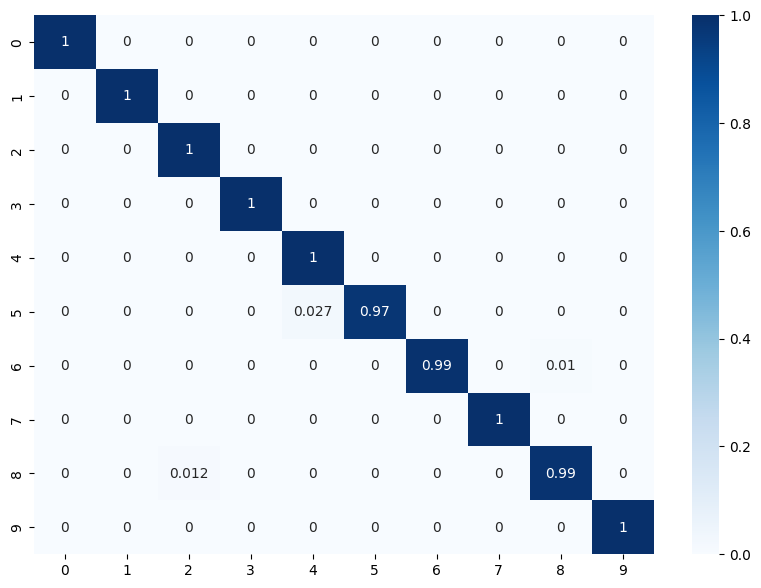

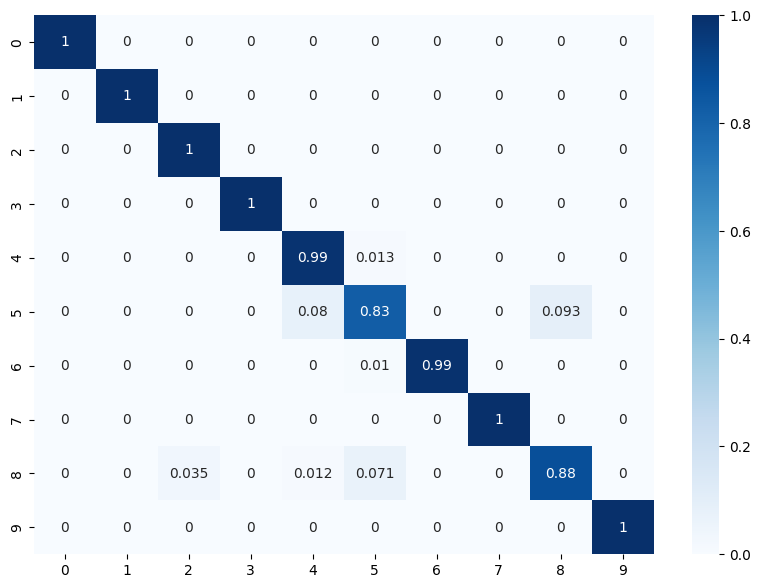

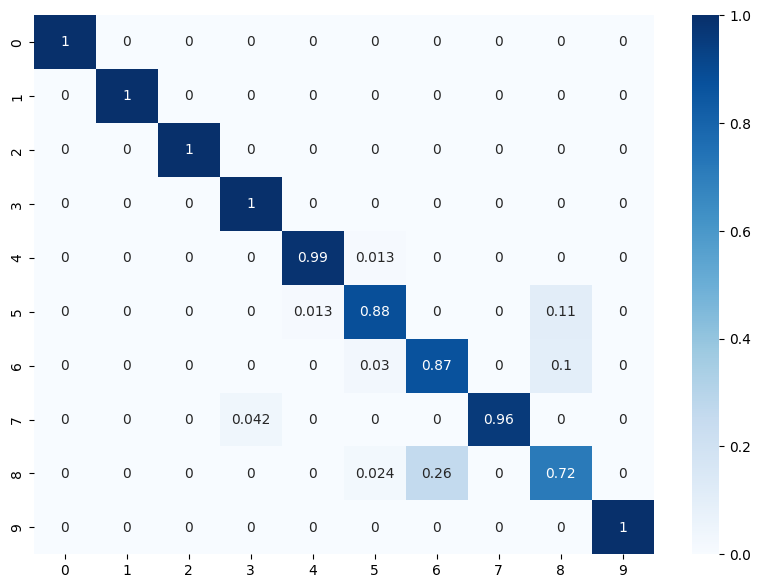

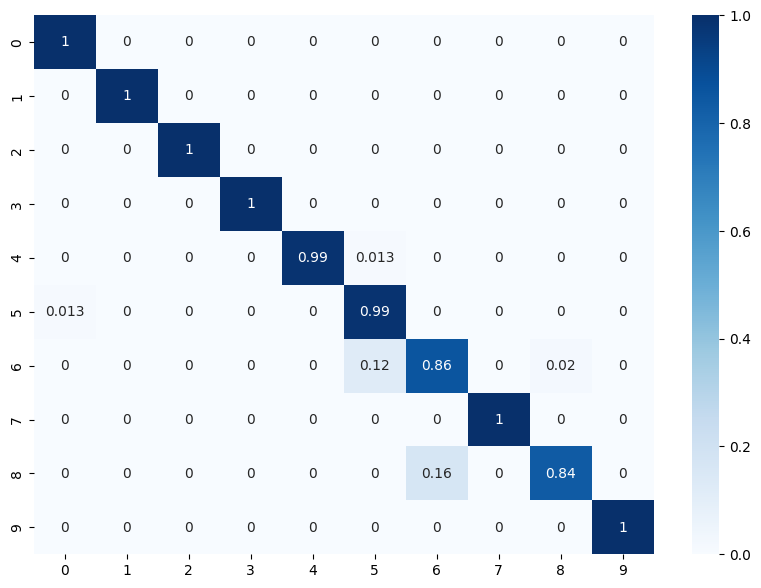

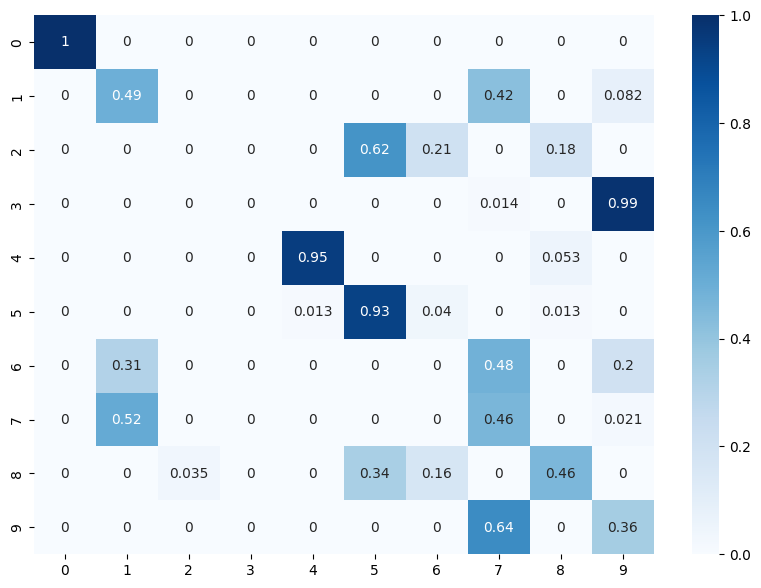

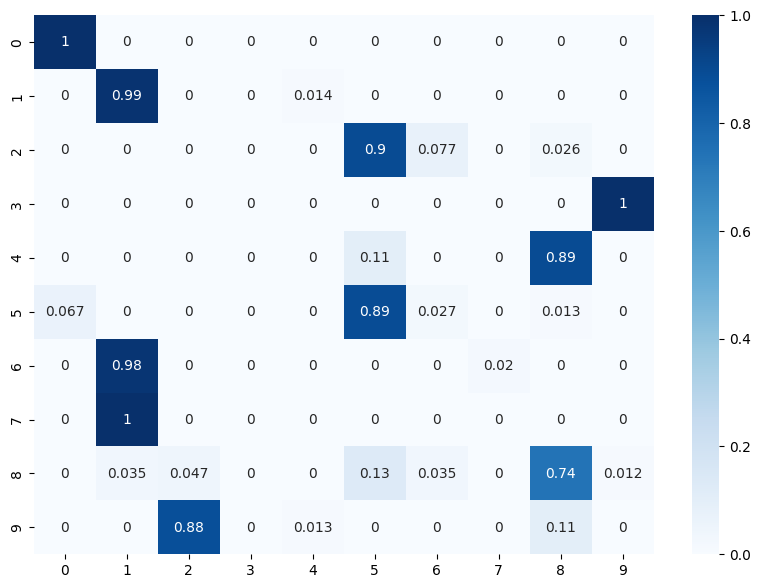

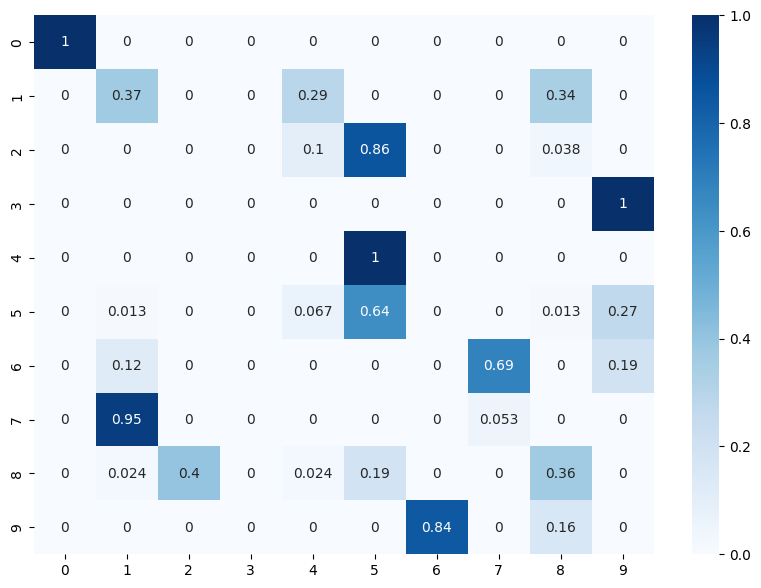

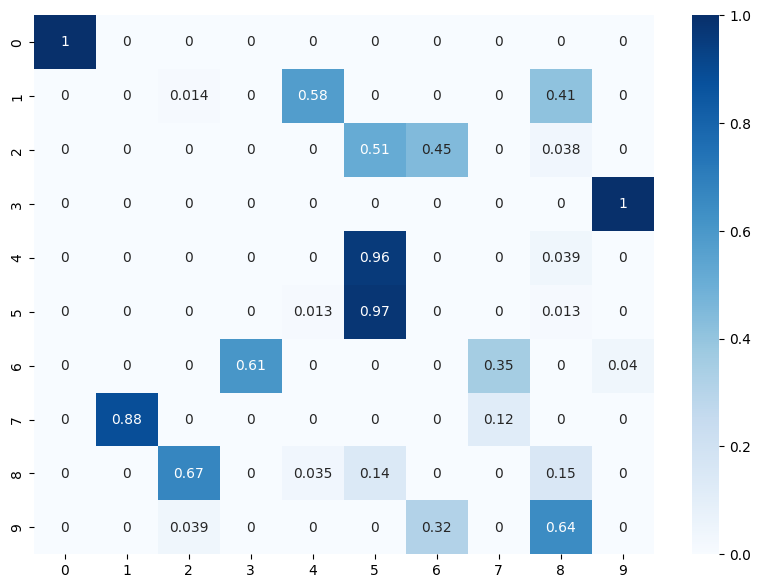

In [12]:
generate_confusion_matrix(encoder_tgt, classifier, test_dataloader_src, "cuda")
src_test_loss, src_test_acc = evaluate_src(encoder_tgt, classifier, phase='Test')
print(f'\t Test (with Source) Loss:{src_test_loss:0.2f} \t Test (with Source) Acc:{src_test_acc:0.2f}') 
for phase in range(len(target_domains)):
    if(phase == 0): # Domain A to B
        print(f'\nPhase {phase + 1} (Domain {source_domain} to Domain {target_domains[phase]})')
    else: # Domain B to C, and Domain C to D
        print(f'\nPhase {phase + 1} (Domain {target_domains[phase - 1]} to Domain {target_domains[phase]})')
    
    generate_confusion_matrix(encoder_tgt, classifier, test_dataloader_tgt[phase], "cuda")
    tgt_test_loss, tgt_test_acc = evaluate_tgt(encoder_tgt, classifier, test_dataloader_tgt[phase])
    print(f'\t Test (with Target) Loss:{tgt_test_loss:0.2f} \t Test (with Target) Acc:{tgt_test_acc:0.2f}') 

In [33]:
def generate_features(encoder, dataloader):
    feature = encoder(dataloader.dataset.data[5].to(device))
    plt.plot(feature.detach().cpu()[0].numpy())
    plt.show()

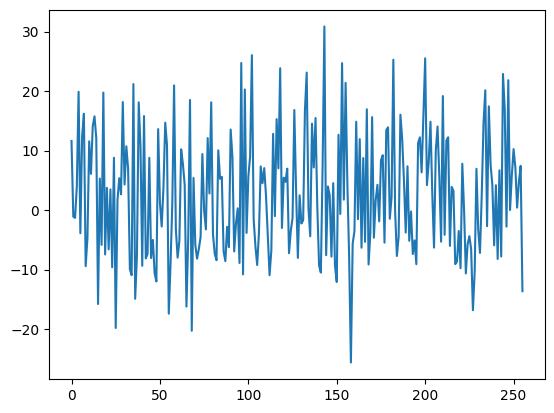

In [34]:
generate_features(encoder_src, test_dataloader_src)

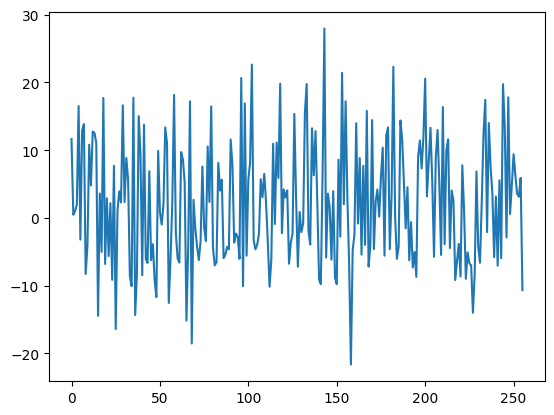

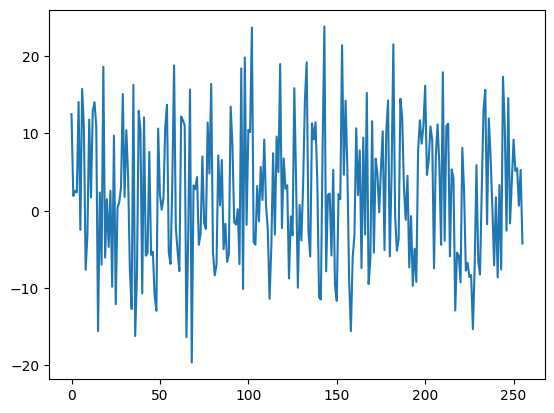

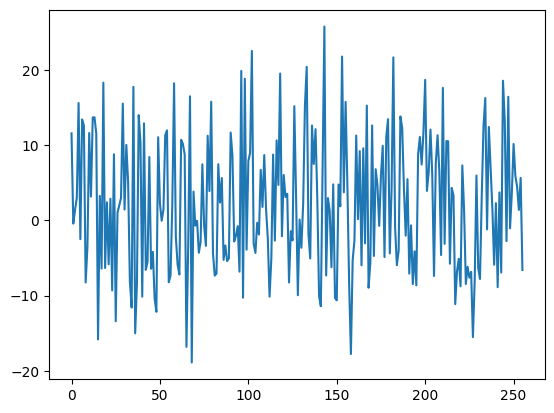

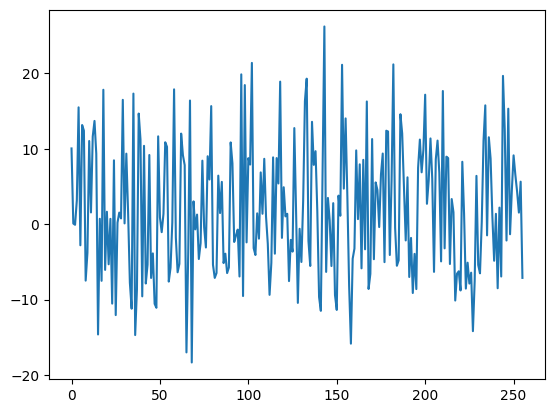

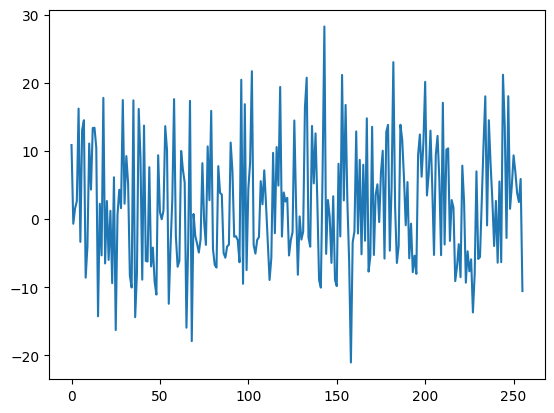

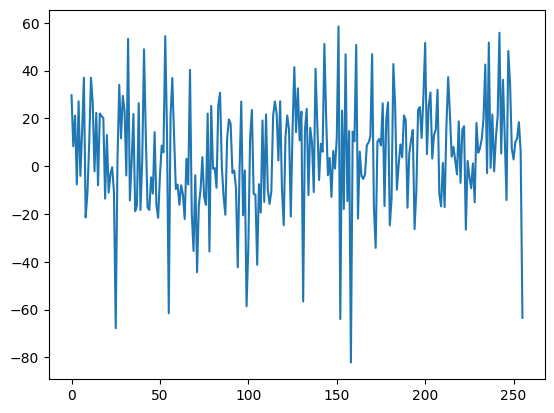

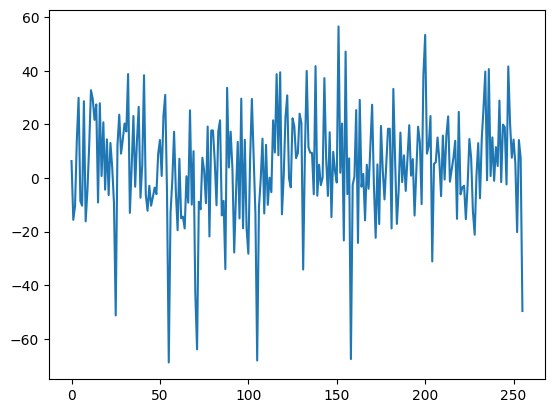

In [35]:
for i in range(len(target_domains)):
    generate_features(encoder_tgt, test_dataloader_tgt[i])